In [21]:
import pickle
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from src.direvo import param_sampler as ps
from src.direvo import populations as pop
from src.direvo import landscapes as ld
from src.direvo import evo_runs
from src.direvo import strategy_evaluation as se
import os
import tqdm

This is example code on how to use the directed evolution code!
 
We put everything into a core function for this example, which is hopefully illustrative: 

In [7]:
def directedEvolution(rng, selection_strategy, selection_params, pre_optimise_steps = 0, empirical = False, N = None, K = None, landscape = None, popsize=100, mut_chance=0.01, num_steps=50, num_reps=10, define_i_pop=None, average=True):
    r1, r2, r3 = jr.split(rng, 3)
 
    # Get initial population.
    if define_i_pop == None:
        i_pop = pop.gen_clustered_initial_population(r1, N, popsize, 0.1)
    else:
        i_pop = define_i_pop
 
    # Function for evaluating fitness.
    if empirical:
        fitness_function = ld.get_pre_defined_landscape_function(landscape)
        mut_method = pop.get_basic_pop_mutation(mut_chance, 20)
    else:
        fitness_function = ld.gen_NK_func(r2, N, K)
        mut_method = pop.get_basic_pop_mutation(mut_chance, 2)
 
    if pre_optimise_steps != 0:
 
        # Define selection function.
        selection_function, init_select_state = pop.select_cells(
            pop.spiking_select, {'threshold': 0.95, 'base_chance' : 0.0})
 
        pre_op = evo_runs.cont_evo_run_extras(
            r3, i_pop, init_select_state, selection_function, mut_method, fitness_func=fitness_function, num_steps=pre_optimise_steps)[1]
 
        i_pop = pre_op['pop'][-1,:,:]
 
    # Define selection function.
    selection_function, init_select_state = pop.select_cells(
        selection_strategy, selection_params)
 
    # Bringing it all together.
    vmapped_run = jax.jit(jax.vmap(lambda r: evo_runs.cont_evo_run_extras(
        r, i_pop, init_select_state, selection_function, mut_method, fitness_func=fitness_function, num_steps=num_steps)[1]))
    # The array of seeds we will take as input.
    rng_seeds = jr.split(rng, num_reps)
    results = vmapped_run(rng_seeds)
 
    return results

Next we define the parameters and run the code:

In [8]:
params = {'threshold': 0.95, 'base_chance' : 0.00}
rng = jr.PRNGKey(26)
rng_pop, rng_eval = jr.split(rng)
i_pop = pop.gen_clustered_initial_population(rng_pop, 10, 100, 0.1)
# Note that mutation chance is *per gene*, so not that same as the paper.
run = directedEvolution(rng_eval, N = 10, K=5, selection_strategy=pop.spiking_select, selection_params = params, popsize=100, mut_chance=0.01, num_steps=100, num_reps=1, define_i_pop=i_pop, average=True)

And here we can plot the final result on this single run:

Text(0, 0.5, 'Fitness')

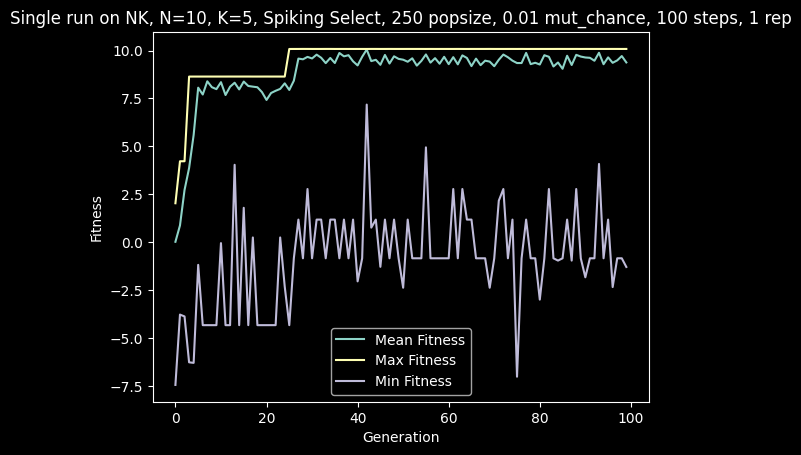

In [27]:
plt.plot(run["fitness"][0].mean(axis = 1), label = "Mean Fitness")
plt.plot(run["fitness"][0].max(axis = 1), label = "Max Fitness")
plt.plot(run["fitness"][0].min(axis = 1), label = "Min Fitness")
plt.legend()
plt.title(f"Single run on NK, N=10, K=5, 100 popsize, 0.01 mut_chance, 100 steps, 1 rep")
plt.xlabel("Generation")
plt.ylabel("Fitness")

And an example using GB1:

In [25]:
rng = jr.PRNGKey(26)
rng_pop, rng_eval = jr.split(rng)
i_pop_GB1 = pop.gen_clustered_initial_population(rng_pop, 4, 100, 0.1, gene_options=20)
GB1_run = directedEvolution(rng_eval ,selection_strategy=pop.spiking_select,selection_params = {'threshold': 0.95, 'base_chance' : 0.0},mut_chance=0.01,num_steps=100,num_reps=100,define_i_pop=i_pop_GB1,average=True,empirical=True,landscape=se.GB1)  

Text(0, 0.5, 'Fitness')

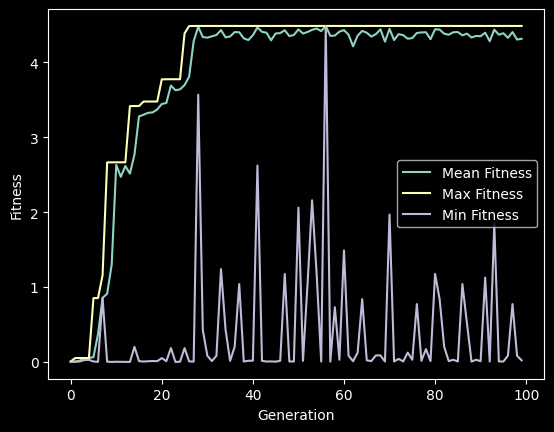

In [26]:
plt.plot(GB1_run["fitness"][0].mean(axis = 1), label = "Mean Fitness")
plt.plot(GB1_run["fitness"][0].max(axis = 1), label = "Max Fitness")
plt.plot(GB1_run["fitness"][0].min(axis = 1), label = "Min Fitness")
plt.legend()
plt.title("Single run on GB1")
plt.xlabel("Generation")
plt.ylabel("Fitness")